# **Data Analysis and Visualization**

In this section, the results obtained in "model_run" will be analyzed and visualized.

In [4]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

**Upload Necessary Data**

In [12]:
# upload the data with the following code
model_dataframe_initial = pd.read_csv(f"../result_sensitivity/{'model_results_initial'}.csv")

# Calculate the new ratio
model_dataframe_initial['cost_damage_ratio'] = (model_dataframe_initial['total_subsidy']+ model_dataframe_initial['total_expenditure_on_adaptations']) / model_dataframe_initial['total_reduced_estimated_damage']
model_dataframe_initial['adaptation_damage_ratio'] = model_dataframe_initial['total_expenditure_on_adaptations'] / model_dataframe_initial['total_reduced_estimated_damage']
model_dataframe_initial['subsidy_damage_ratio'] = model_dataframe_initial['total_subsidy'] / model_dataframe_initial['total_reduced_estimated_damage']

In [13]:
# Define the file paths and parameters
file_paths = {
    "income_threshold": "../result_sensitivity/model_sensitivity_results_income_threshold.csv",
    "saving_threshold": "../result_sensitivity/model_sensitivity_results_saving_threshold.csv",
    "subsidy_rate": "../result_sensitivity/model_sensitivity_results_subsidy_rate.csv",
    "flood_prob": "../result_sensitivity/model_sensitivity_results_flood_prob.csv"
}

parameter_column_names = {
    "income_threshold": "income_threshold",
    "saving_threshold": "rate",
    "subsidy_rate": "subsidy_rate",
    "flood_prob": "flood_probability"
}

parameters = {
    "income_threshold": [3600, 4000, 4400],
    "saving_threshold": [0.45, 0.5, 0.55],
    "subsidy_rate": [0.45, 0.5, 0.55],
    "flood_prob": [0.063, 0.07, 0.077]
}

# **Intial data analysis**

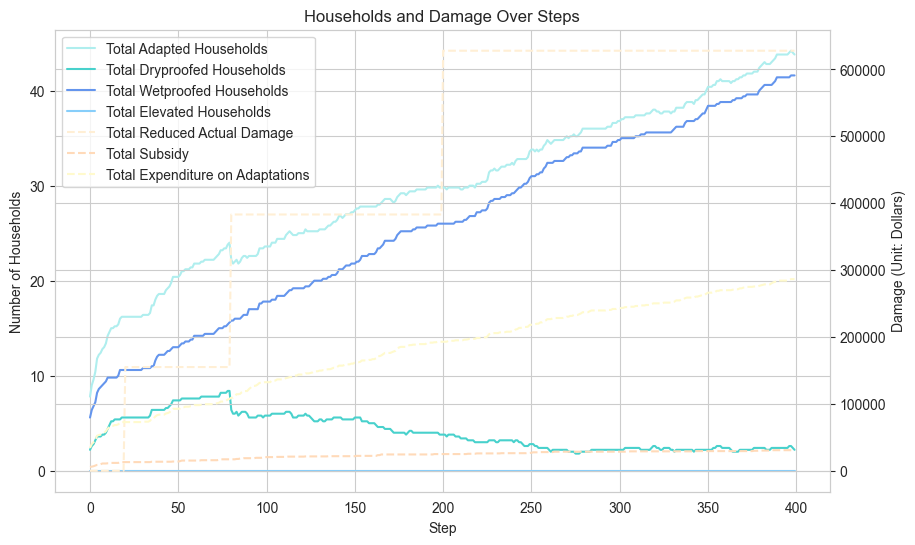

In [14]:
def create_dual_axis_line_chart(dataframe, left_y_data, right_y_data, warm_colors, cold_colors, title):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot data for the left Y-axis
    for index, (column, label) in enumerate(left_y_data):
        ax1.plot(dataframe['Step'], dataframe[column], label=label, linestyle='-', color=cold_colors[index])

    # Plot data for the right Y-axis
    for index, (column, label) in enumerate(right_y_data):
        ax2.plot(dataframe['Step'], dataframe[column], label=label, linestyle='--', color=warm_colors[index])

    # Add labels and title
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Number of Households')
    ax2.set_ylabel('Damage (Unit: Dollars)')
    plt.title(title)

    # Show the legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    plt.legend(lines, labels)

    # Show the grid and display the chart
    ax1.grid(True)
    plt.show()

# Define warm and cold colors
warm_colors = ['PapayaWhip', 'PeachPuff', 'LemonChiffon', 'Pink', 'LightSalmon', 'Red']
cold_colors = ['PaleTurquoise', 'MediumTurquoise', 'CornflowerBlue', 'LightSkyBlue']

# Define data for each axis
left_y_data = [
    ('total_adapted_households', 'Total Adapted Households'),
    ('total_dryproofed_households', 'Total Dryproofed Households'),
    ('total_wetproofed_households', 'Total Wetproofed Households'),
    ('total_elevated_households', 'Total Elevated Households')
]

right_y_data = [
    ('total_reduced_actual_damage', 'Total Reduced Actual Damage'),
    # ('total_actual_damage', 'Total Actual Damage'),
    # ('total_reduced_estimated_damage', 'Total Reduced Estimated Damage'),
    ('total_subsidy', 'Total Subsidy'),
    ('total_expenditure_on_adaptations', 'Total Expenditure on Adaptations')
]

# right_y_data = [('cost_damage_ratio', 'cost_damage_ratio'),
#                 ('subsidy_damage_ratio', 'subsidy_damage_ratio'),
#                 ('adaptation_damage_ratio', 'adaptation_damage_ratio')]

# Prepare your dataframe
grouped_data = model_dataframe_initial.groupby('Step').agg('mean').reset_index()

# Call the function to create the plot
create_dual_axis_line_chart(grouped_data, left_y_data, right_y_data, warm_colors, cold_colors, 'Households and Damage Over Steps')

# **Multiple Parameter Sensitivity Analysis**

In [15]:
def load_and_filter_dataframe(file_path, step=399):
    df = pd.read_csv(file_path)
    return df[df['Step'] == step]

def calculate_statistics(dataframe, column_name, parameter_name, parameter_values):
    results = {}
    for value in parameter_values:
        filtered_df = dataframe[dataframe[parameter_name] == value]
        mean_val = filtered_df[column_name].mean()
        max_val = filtered_df[column_name].max()
        min_val = filtered_df[column_name].min()
        results[value] = [mean_val, max_val, min_val]
    return results

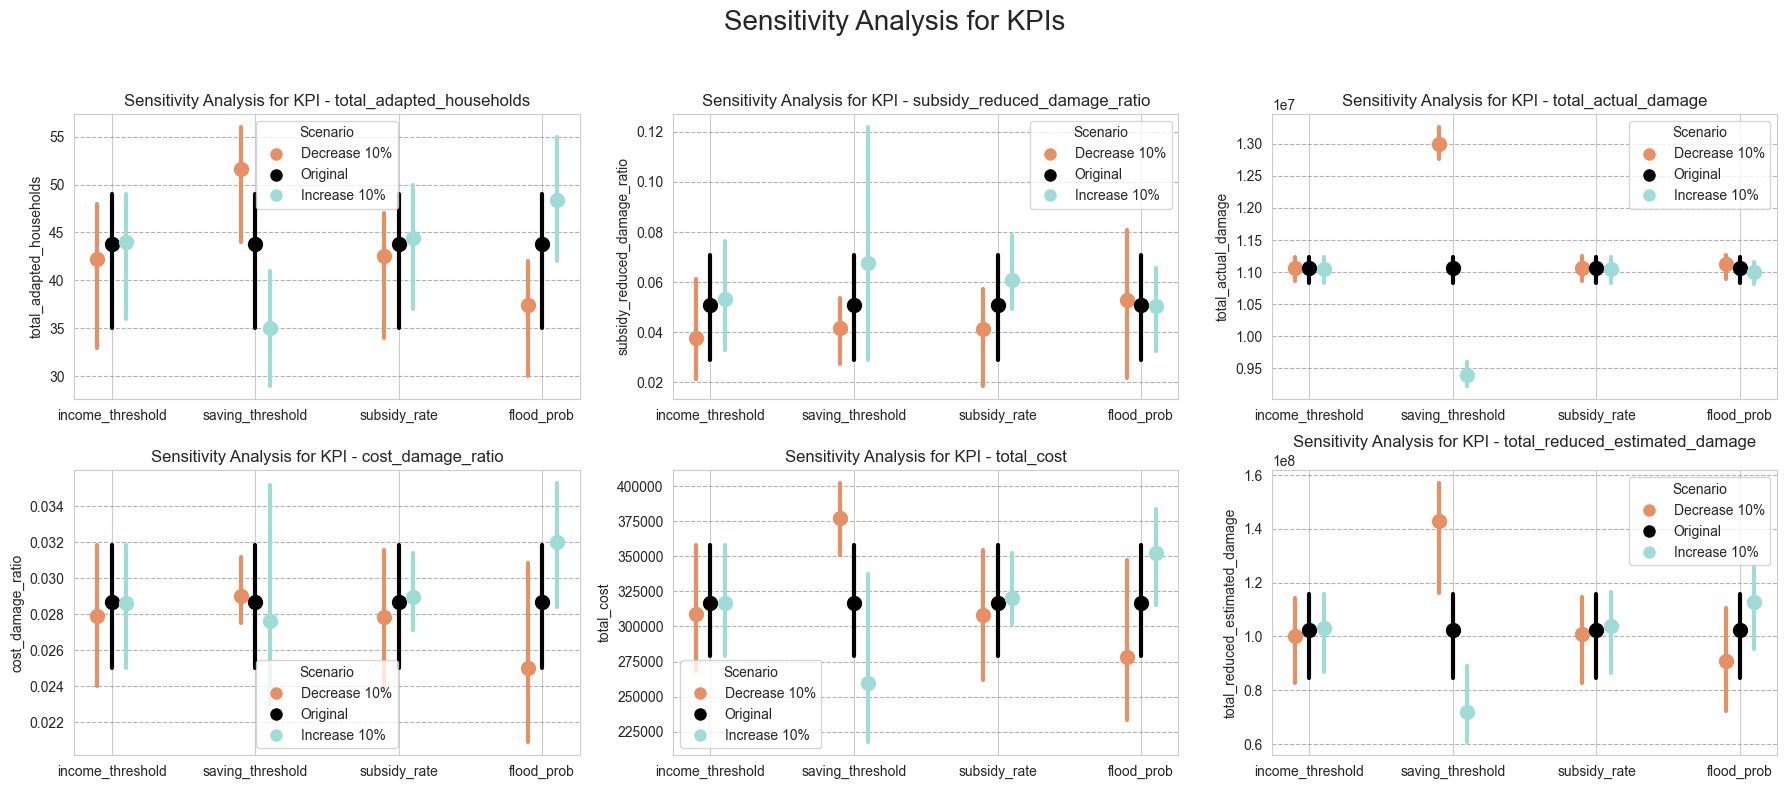

In [21]:

# Define the list of KPIs you want to analyze
kpis = ['total_adapted_households', 
        'subsidy_reduced_damage_ratio',
        'total_actual_damage',   
        'cost_damage_ratio', 
        'total_cost', 
        'total_reduced_estimated_damage']  # Replace kpis

# print(df.columns)
# Define the number of rows and columns for the subplots
num_rows = 2  # Set the desired number of rows
num_cols = 3  # Set the desired number of columns

# Create a figure with the defined number of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Initialize a dictionary to store all results for each KPI
data_kpis = {kpi: {} for kpi in kpis}

# Loop through each DataFrame and calculate statistics for each KPI
for kpi in kpis:
    for key, file_path in file_paths.items():
        df = load_and_filter_dataframe(file_path)
        # Special handling for the subsidy_damage_ratio KPI
        if kpi == 'subsidy_reduced_damage_ratio':
            df['subsidy_reduced_damage_ratio'] = np.where(df['total_reduced_actual_damage'] != 0, 
                                                  df['total_subsidy'] / df['total_reduced_actual_damage'], 
                                                  np.nan)
        elif kpi == 'cost_damage_ratio':
            df['cost_damage_ratio'] = np.where(df['total_actual_damage'] != 0,
                                               (df['total_subsidy']+ df['total_expenditure_on_adaptations']) / df['total_actual_damage'], 
                                                  np.nan)
        elif kpi == 'total_cost':
            df['total_cost'] = np.where(df['total_actual_damage'] != 0, 
                                                  df['total_subsidy']+ df['total_expenditure_on_adaptations'], 
                                                  np.nan)
        parameter_name = parameter_column_names[key]
        statistics = calculate_statistics(df, kpi, parameter_name, parameters[key])
        data_kpis[kpi][key] = statistics

# Define new colors and labels for the graph
colors = ['#e79063', 'black', '#9edcd8']
scenario_labels = ['Decrease 10%', 'Original', 'Increase 10%']

# Plot each set of points for each KPI
for ax, (kpi, data_kpi) in zip(axes, data_kpis.items()):
    offset = 0.1  # Offset for scenarios from the central axis
    whisker_width = 3  # Width of the whisker lines

    for i, (variable, scenarios) in enumerate(data_kpi.items()):
        position = i
        for j, (level, values) in enumerate(scenarios.items()):
            scenario_offset = (j - 1) * offset
            median_value = np.median(values)
            min_value = np.min(values)
            max_value = np.max(values)

            # Draw the whisker line and median dot
            ax.plot([position + scenario_offset] * 2, [min_value, max_value], '-', color=colors[j], linewidth=whisker_width)
            ax.plot(position + scenario_offset, median_value, 'o', color=colors[j], markersize=10)

    # Set the labels for the x-ticks
    ax.set_xticks(range(len(data_kpi)))
    ax.set_xticklabels([variable for variable in data_kpi.keys()], rotation=0)

    # Set the axis labels and title
    ax.set_ylabel(kpi)
    ax.set_title(f'Sensitivity Analysis for KPI - {kpi}')

    # Add a custom legend and grid
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, scenario_labels)]
    ax.legend(handles=legend_elements, title='Scenario')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

# Hide any unused subplots
for i in range(len(data_kpis), len(axes)):
    axes[i].set_visible(False)

# Set the title for the entire figure
fig.suptitle('Sensitivity Analysis for KPIs', fontsize=20)

plt.tight_layout()
fig.subplots_adjust(top= 0.85) # Adjust the top spacing to accommodate the figure title
plt.show()


# **make Y axis to represent ratio**

NameError: name 'file_paths' is not defined

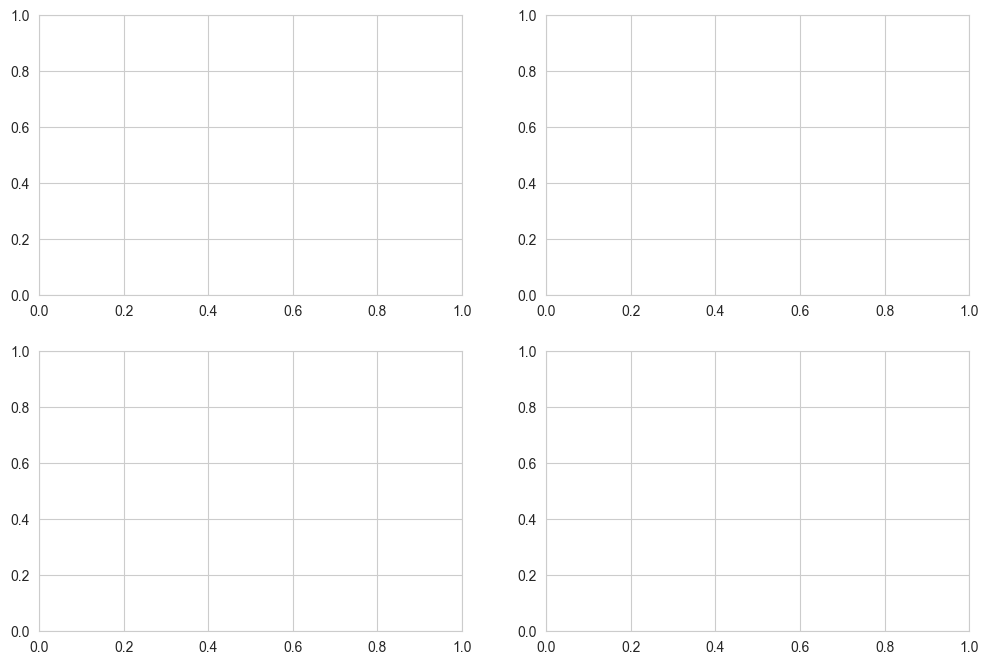

In [11]:
def calculate_ratio_statistics(dataframe, kpi, parameter_name, parameter_values):
    results = {}
    original_df = dataframe[dataframe[parameter_name] == parameter_values[1]]  # Assuming the second value is the original

    for value in parameter_values:
        filtered_df = dataframe[dataframe[parameter_name] == value]
        mean_val = filtered_df[kpi].mean() / original_df[kpi].mean() if original_df[kpi].mean() != 0 else np.nan
        max_val = filtered_df[kpi].max() / filtered_df[kpi].mean() if filtered_df[kpi].mean() != 0 else np.nan
        min_val = filtered_df[kpi].min() / filtered_df[kpi].mean() if filtered_df[kpi].mean() != 0 else np.nan
        max_val1 = max_val* mean_val
        min_val1 = min_val* mean_val
        results[value] = [mean_val, max_val1, min_val1]

    return results
# Define the list of KPIs you want to analyze
kpis = ['total_adapted_households', 
        'total_reduced_estimated_damage', 
        # 'total_actual_damage', 
        # 'total_subsidy', 
        # 'total_expenditure_on_adaptations',  
        'total_cost_damage_ratio', 
        # 'expenditure_damage_ratio', 
        # 'total_reduced_actual_damage',
        'subsidy_damage_ratio']

# Define the number of rows and columns for the subplots
num_rows = 2
num_cols = 2

# Create a figure with the defined number of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
axes = axes.flatten()

# Initialize a dictionary to store all results for each KPI
data_kpis = {kpi: {} for kpi in kpis}

# Loop through each DataFrame and calculate ratio statistics for each KPI
for kpi in kpis:
    for key, file_path in file_paths.items():
        df = load_and_filter_dataframe(file_path)
        if kpi == 'subsidy_damage_ratio':
            df['subsidy_damage_ratio'] = np.where(df['total_reduced_estimated_damage'] != 0, 
                                                  df['total_subsidy'] / df['total_reduced_estimated_damage'], 
                                                  np.nan)
        elif kpi == 'total_cost_damage_ratio':
            df['total_cost_damage_ratio'] = np.where(df['total_reduced_estimated_damage'] != 0, 
                                                  df['total_subsidy']+ df['total_expenditure_on_adaptations'] / df['total_reduced_estimated_damage'], 
                                                  np.nan)
        elif kpi == 'expenditure_damage_ratio':
            df['expenditure_damage_ratio'] = np.where(df['total_reduced_estimated_damage'] != 0, 
                                                  df['total_expenditure_on_adaptations'] / df['total_reduced_estimated_damage'], 
                                                  np.nan)
        parameter_name = parameter_column_names[key]
        statistics = calculate_ratio_statistics(df, kpi, parameter_name, parameters[key])
        data_kpis[kpi][key] = statistics

# Define new colors and labels for the graph
colors = ['#e79063', 'black', '#9edcd8']
scenario_labels = ['Decrease 10%', 'Original', 'Increase 10%']

# Plot each set of points for each KPI
for ax, (kpi, data_kpi) in zip(axes, data_kpis.items()):
    offset = 0.1  # Offset for scenarios from the central axis
    whisker_width = 3  # Width of the whisker lines

    for i, (variable, scenarios) in enumerate(data_kpi.items()):
        position = i
        for j, (level, values) in enumerate(scenarios.items()):
            scenario_offset = (j - 1) * offset
            median_value = values[0]  # Mean is used as median
            min_value = values[2]  # Min value
            max_value = values[1]  # Max value

            # Draw the whisker line and median dot
            ax.plot([position + scenario_offset] * 2, [min_value, max_value], '-', color=colors[j], linewidth=whisker_width)
            ax.plot(position + scenario_offset, median_value, 'o', color=colors[j], markersize=10)
    ax.set_xticks(range(len(data_kpi)))
    ax.set_xticklabels([variable for variable in data_kpi.keys()], rotation=0)

    ax.set_ylabel(f'Ratio of {kpi}')
    ax.set_title(f'Sensitivity Analysis for KPI - {kpi}')

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, scenario_labels)]
    ax.legend(handles=legend_elements, title='Scenario')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

for i in range(len(data_kpis), len(axes)):
    axes[i].set_visible(False)
    
# Initialize variables to store the global min and max values
global_min = float('inf')
global_max = float('-inf')

# Calculate the global min and max values across all KPIs
for kpi, data_kpi in data_kpis.items():
    for variable, scenarios in data_kpi.items():
        for level, values in scenarios.items():
            min_value = values[2]
            max_value = values[1]
            global_min = min(global_min, min_value)
            global_max = max(global_max, max_value)
            
# Set the same y-axis scale for all subplots
for ax in axes:
    ax.set_ylim(global_min, global_max)

fig.suptitle('Sensitivity Analysis for KPIs', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top= 0.9)
plt.show()